# Carga de datos

In [1]:
!pip install medmnist --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [3]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download)
val_dataset = DataClass(split='val', download=download)
test_dataset = DataClass(split='test', download=download)

# encapsulate data into dataloader form
#train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 32657349/32657349 [00:06<00:00, 4847064.36it/s]


Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz


In [4]:
import warnings; warnings.filterwarnings('ignore'); from sklearn.metrics import accuracy_score

In [5]:
import numpy as np

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)

labels = list(train_dataset.info["label"].values())
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(971, 28, 28, 28) (971, 1) (610, 28, 28, 28) (610, 1)


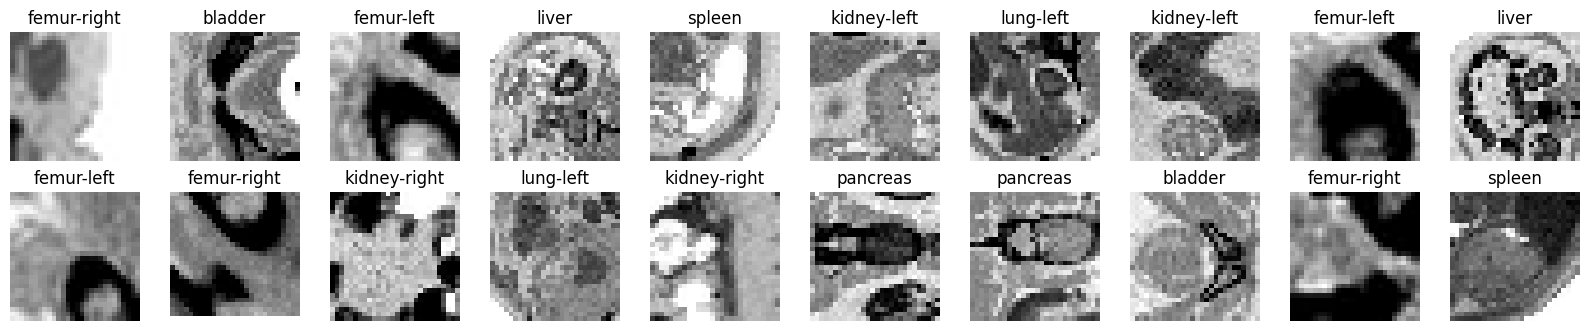

In [6]:
import matplotlib.pyplot as plt
nrows = 2; ncols = 10
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16*nrows/ncols), constrained_layout=True)
for ax, x, y in zip(axs.flat, X_train, y_train):
  ax.set_axis_off(); image = (x[:,:,0]*255).astype(np.uint8); ax.set_title(labels[y[0]])
  ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")


In [7]:
x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32).reshape(x.shape[0], 28*28*28); y_train = np.squeeze(y.astype(np.uint8))

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32).reshape(x.shape[0], 28*28*28); y_val = np.squeeze(y.astype(np.uint8))

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32).reshape(x.shape[0], 28*28*28); y_test = np.squeeze(y.astype(np.uint8))

# Remove for neural networks
X_train, y_train = np.concatenate((X_train, X_val), axis=0), np.concatenate((y_train, y_val), axis=0)

labels = list(train_dataset.info["label"].values())
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1132, 21952) (1132,) (610, 21952) (610,)


# Aplicación de modelos
## Naive Bayes

In [8]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB(var_smoothing=1e-9).fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'La precisión de {clf!s} es {acc:.1%}')


La precisión de GaussianNB() es 66.4%


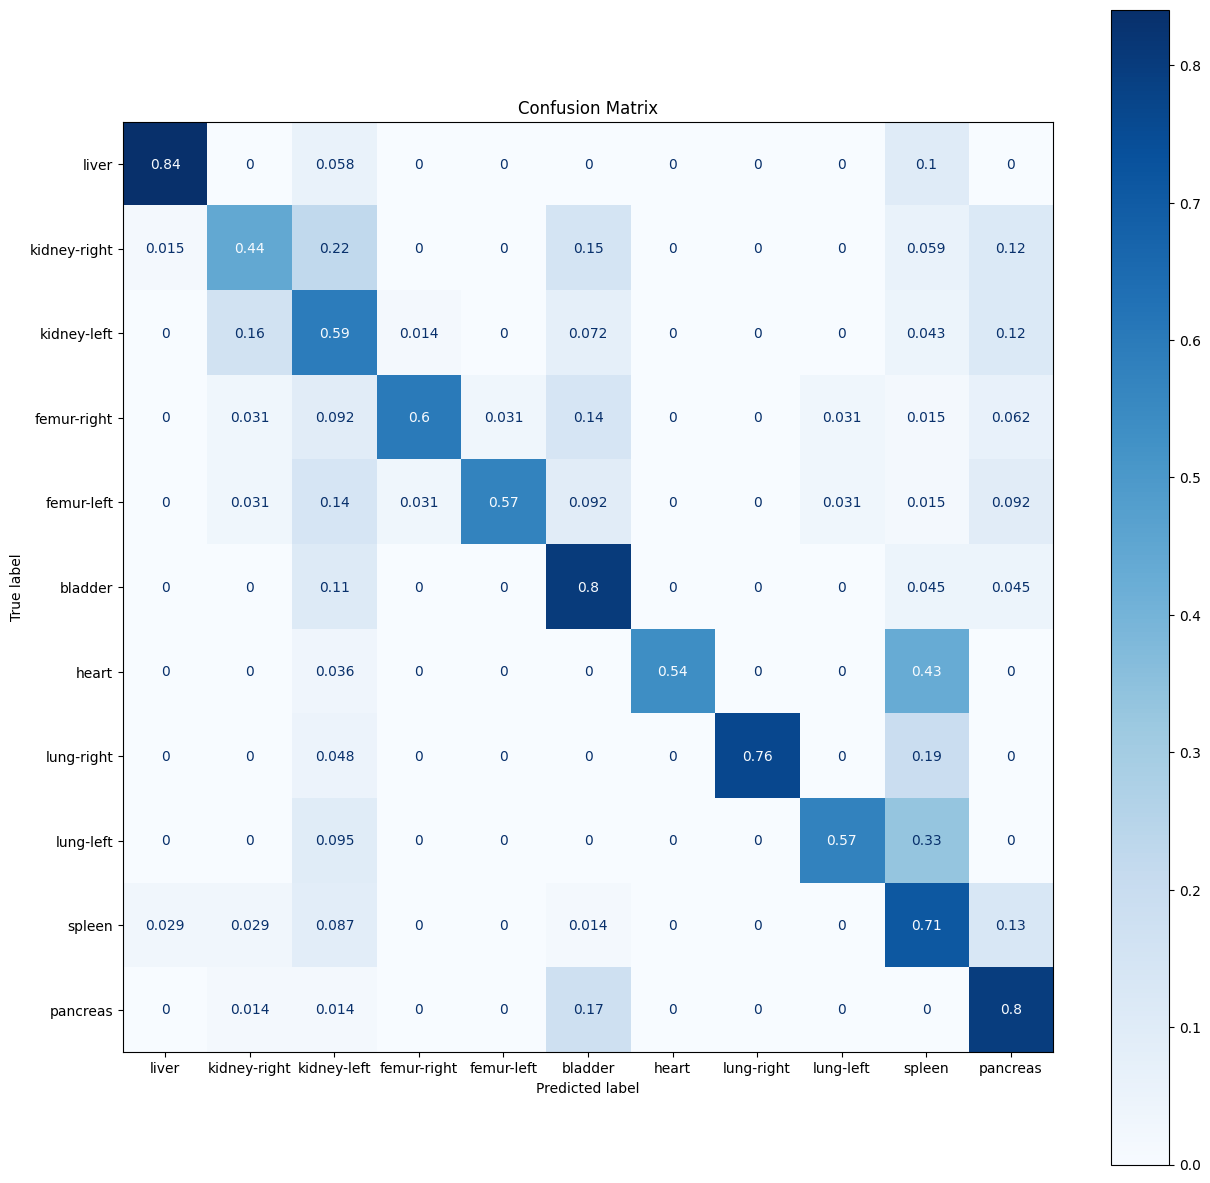

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
np.set_printoptions(precision=2)

disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=labels,
        cmap=plt.cm.Blues,
        normalize="true",
    )
disp.ax_.set_title("Confusion Matrix")
fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(15)

#print("Confusion Matrix")
#print(disp.confusion_matrix)

plt.show()

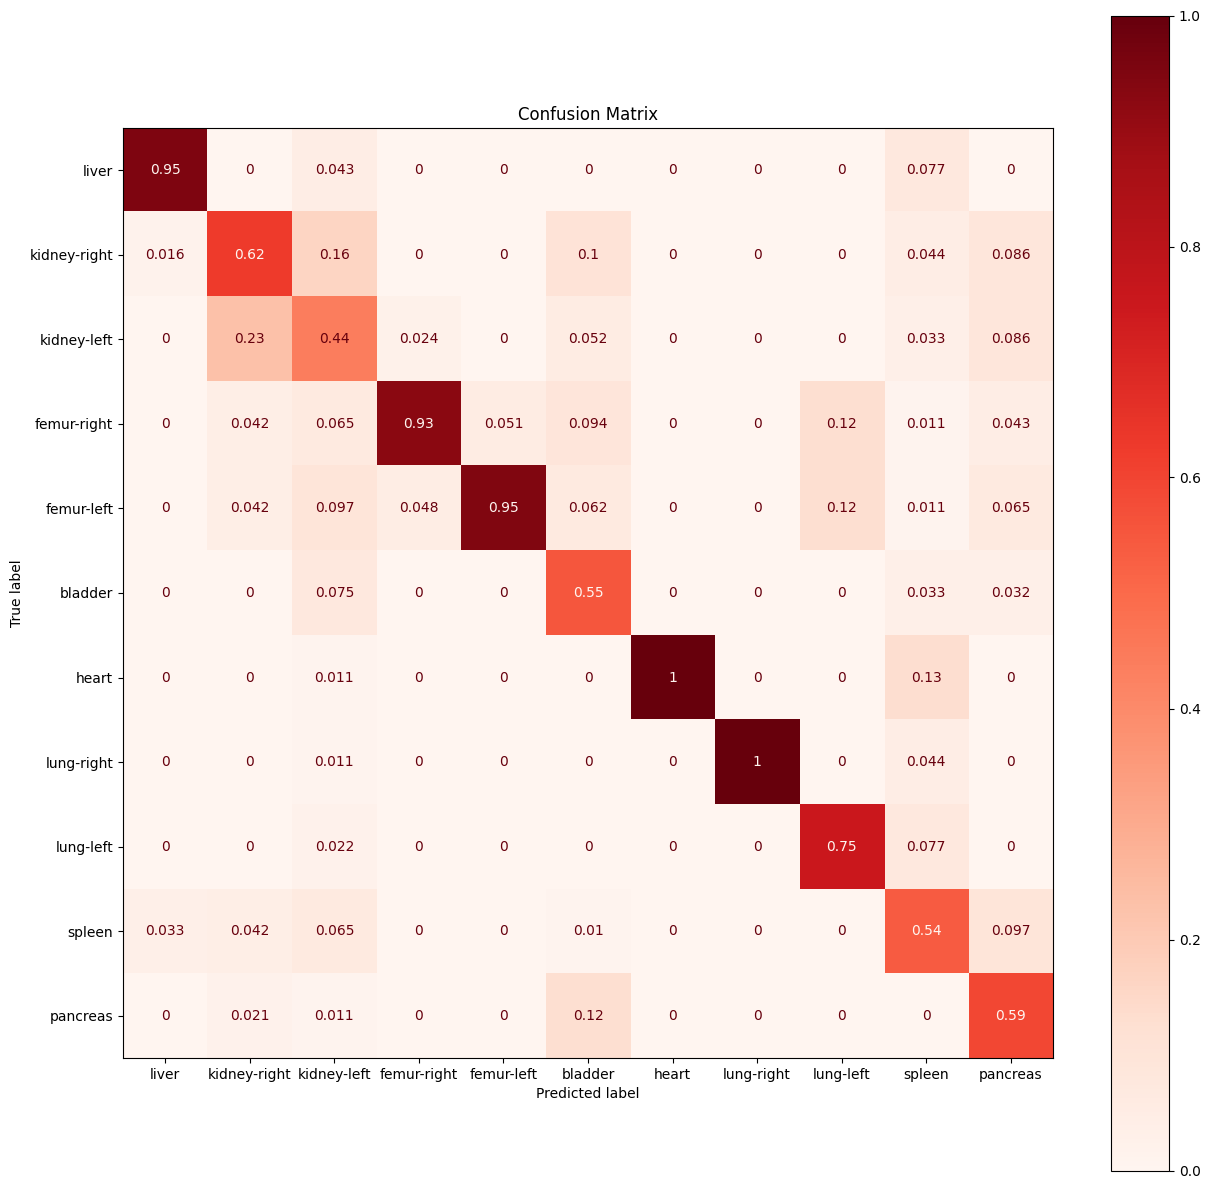

In [10]:
disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=labels,
        cmap=plt.cm.Reds,
        normalize="pred",
    )
disp.ax_.set_title("Confusion Matrix")
fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(15)

#print("Confusion Matrix")
#print(disp.confusion_matrix)

plt.show()

## Análisis discriminante lineal (LDA)

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis(tol=1e-4).fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'La precisión de {clf!s} es {acc:.1%}')


La precisión de LinearDiscriminantAnalysis() es 69.2%


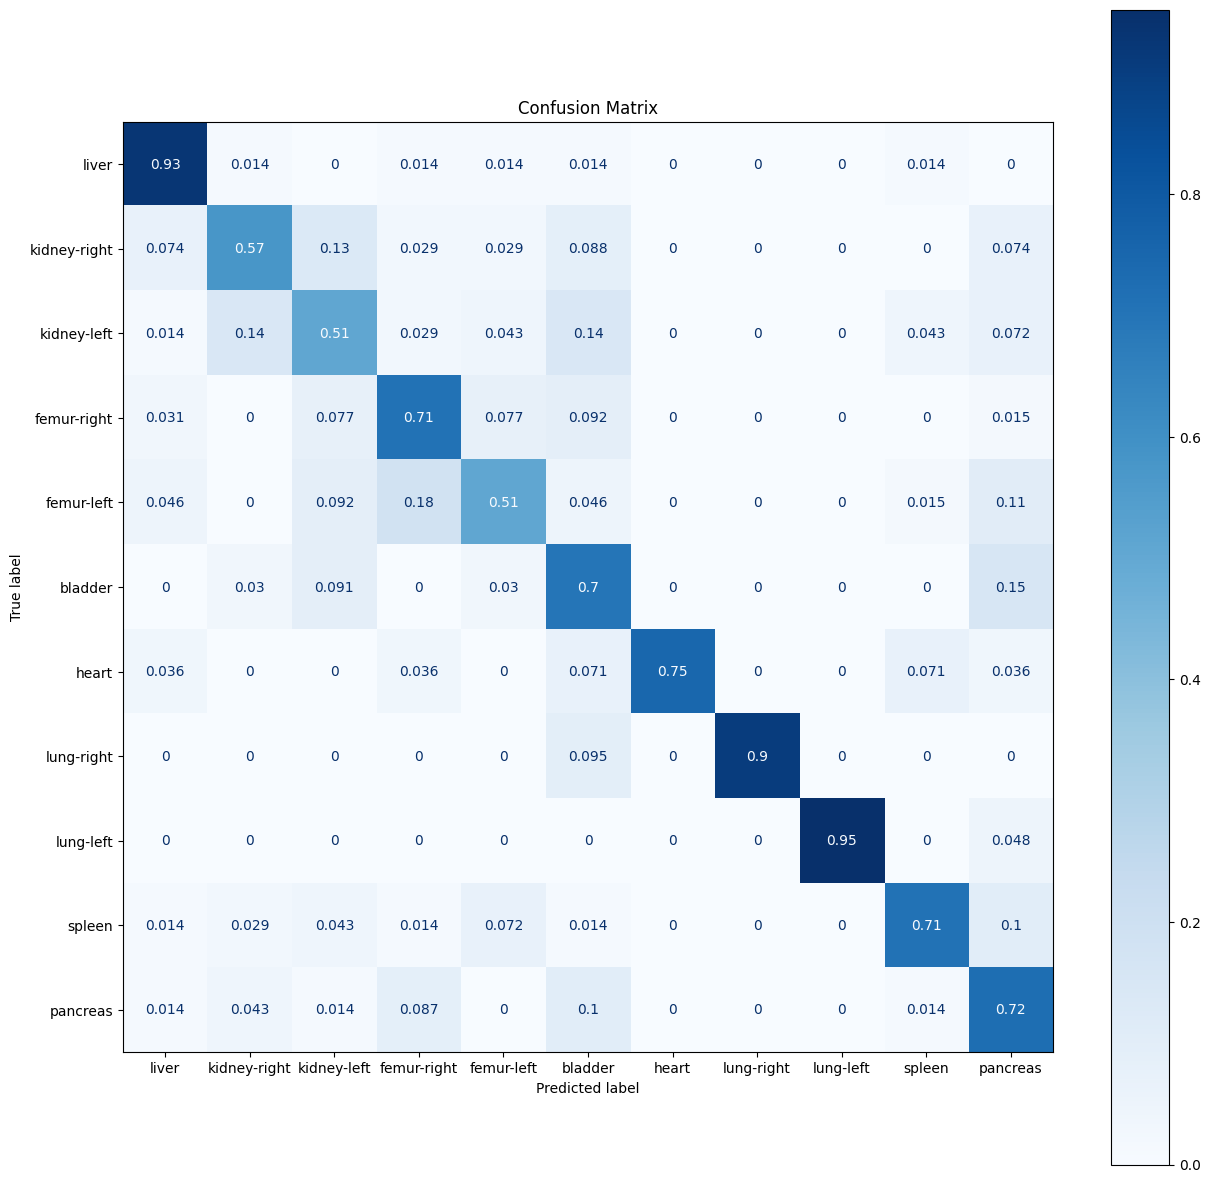

In [12]:
disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=labels,
        cmap=plt.cm.Blues,
        normalize="true",
    )
disp.ax_.set_title("Confusion Matrix")
fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(15)

#print("Confusion Matrix")
#print(disp.confusion_matrix)

plt.show()

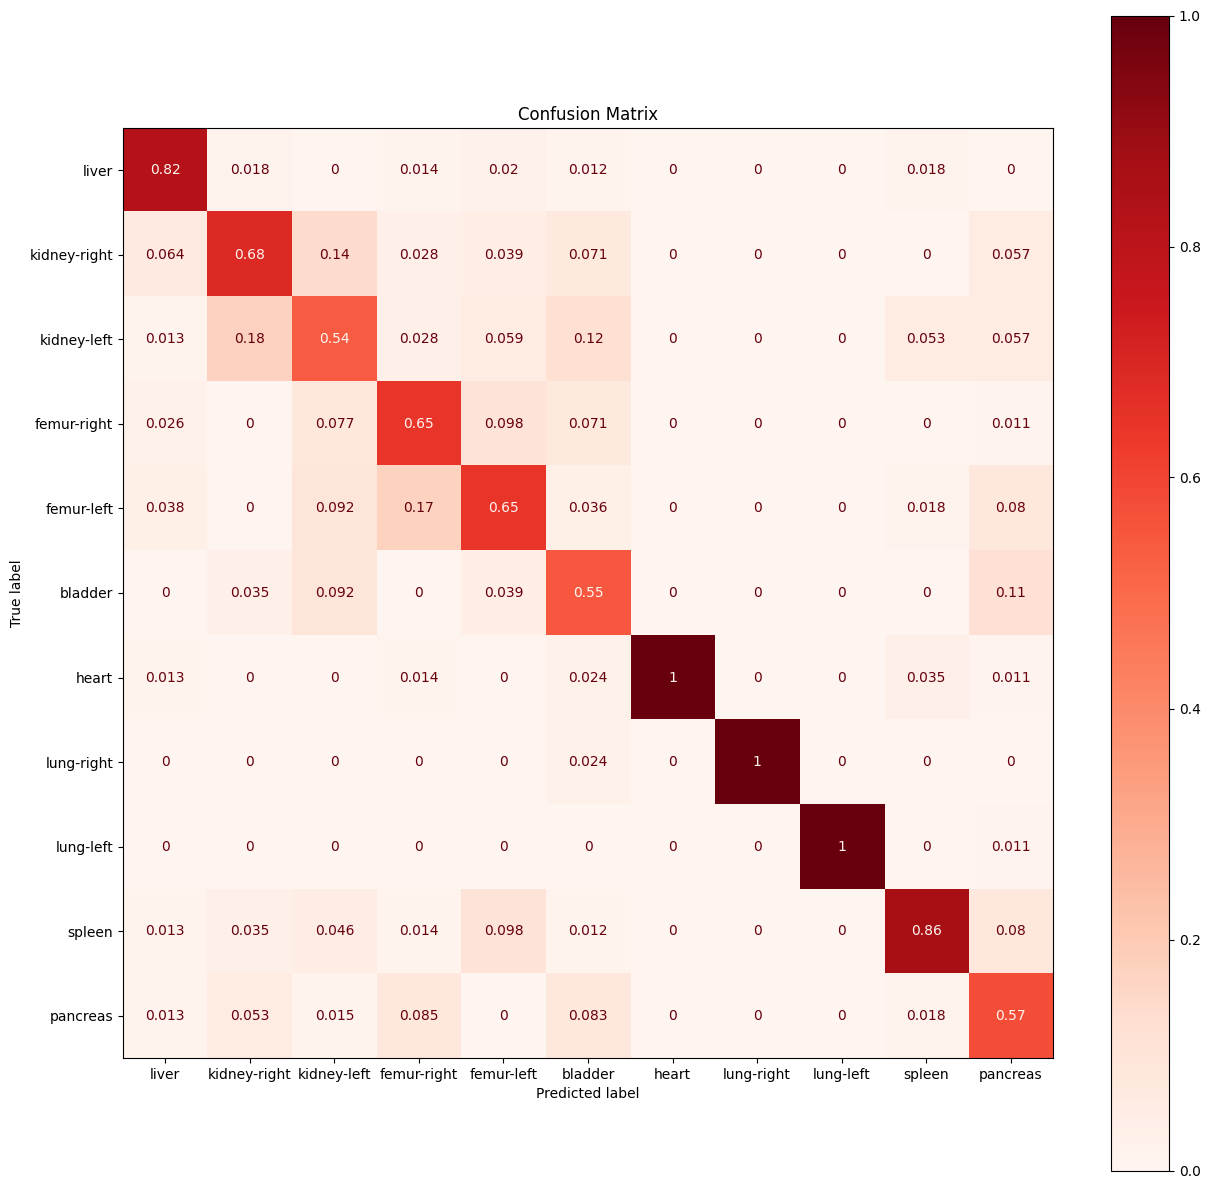

In [13]:
disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=labels,
        cmap=plt.cm.Reds,
        normalize="pred",
    )
disp.ax_.set_title("Confusion Matrix")
fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(15)

#print("Confusion Matrix")
#print(disp.confusion_matrix)

plt.show()

##  Análisis discriminante cuadrático (QDA)

In [14]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pca = PCA(); qda = QuadraticDiscriminantAnalysis()
pipe = Pipeline(steps=[("pca", pca), ("qda", qda)])
G = {"pca__n_components": [60, 70, 80], "qda__reg_param": [0.01, 0.02, 0.05]}
GS = GridSearchCV(pipe, G, scoring='accuracy', refit=True, cv=5)
acc = GS.fit(X_train, y_train).score(X_test, y_test)
print(f'Precisión: {acc:.1%} con {GS.best_params_}')


Precisión: 75.7% con {'pca__n_components': 60, 'qda__reg_param': 0.05}


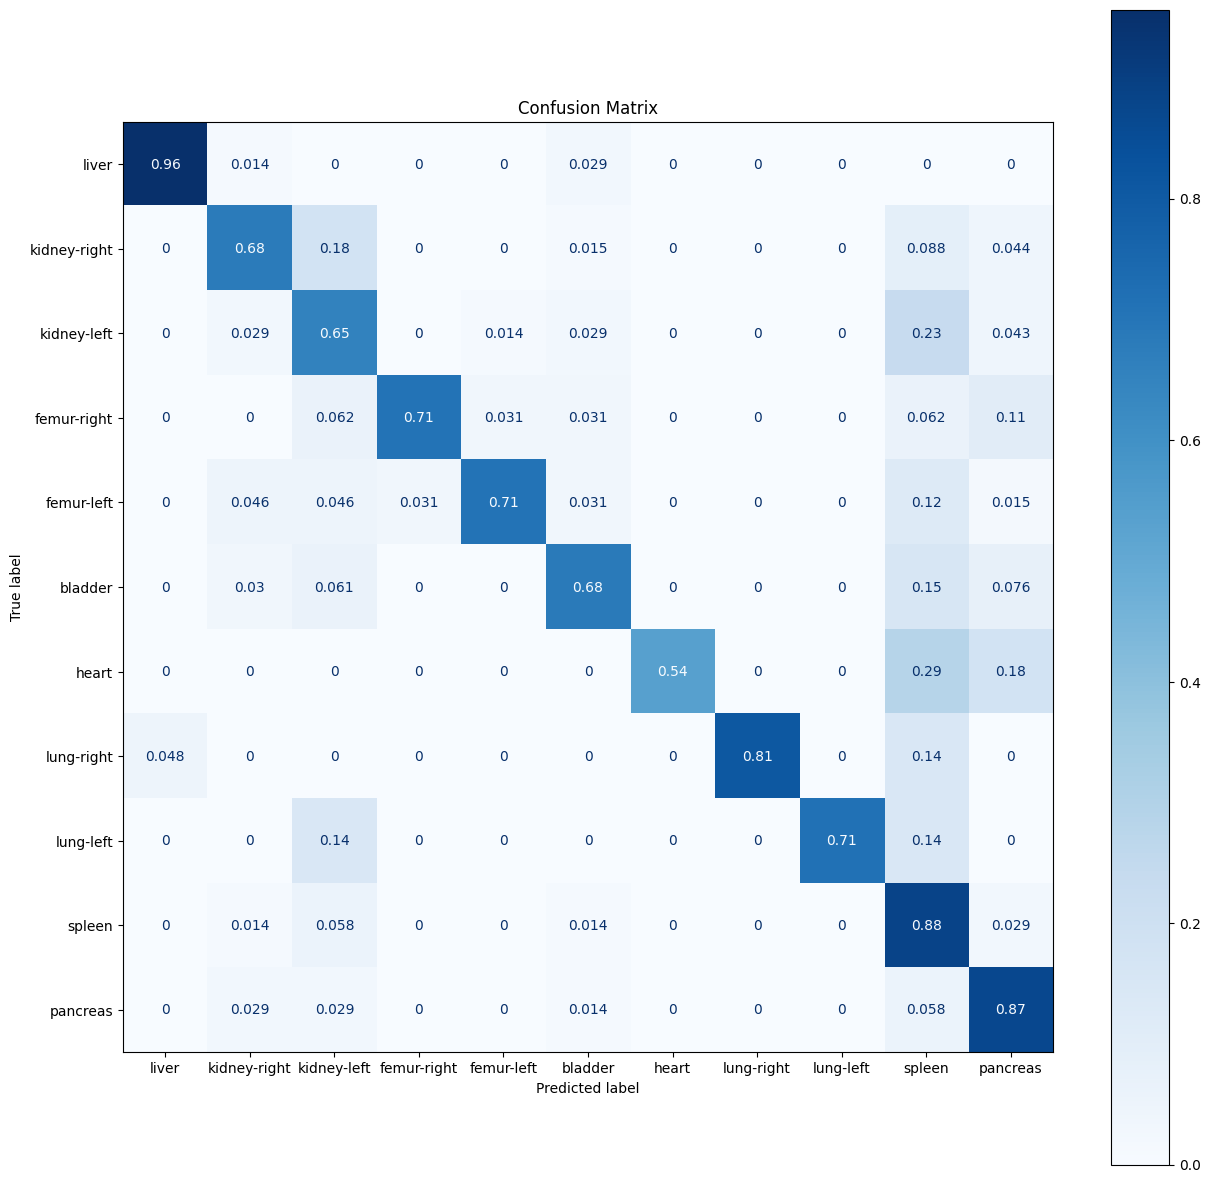

In [15]:
disp = ConfusionMatrixDisplay.from_estimator(
        GS,
        X_test,
        y_test,
        display_labels=labels,
        cmap=plt.cm.Blues,
        normalize="true",
    )
disp.ax_.set_title("Confusion Matrix")
fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(15)

#print("Confusion Matrix")
#print(disp.confusion_matrix)

plt.show()

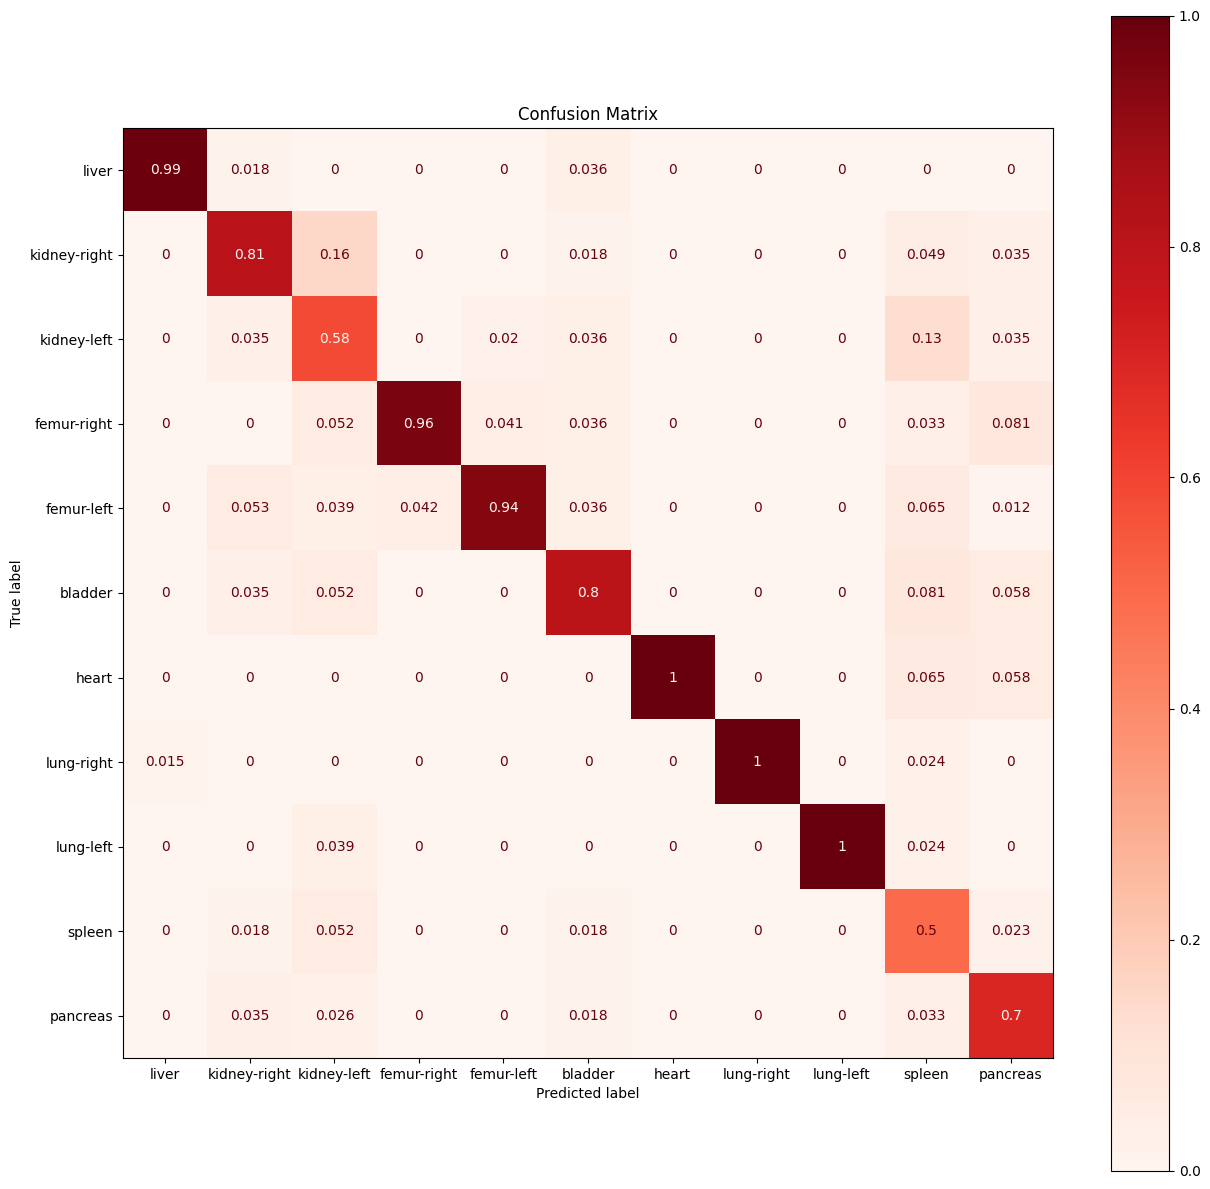

In [17]:
disp = ConfusionMatrixDisplay.from_estimator(
        GS,
        X_test,
        y_test,
        display_labels=labels,
        cmap=plt.cm.Reds,
        normalize="pred",
    )
disp.ax_.set_title("Confusion Matrix")
fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(15)

#print("Confusion Matrix")
#print(disp.confusion_matrix)

plt.show()